### Goal
1. Determine whether or not the Heritage Foundation's Economic Freedom Index correlates expectedly with the FDI restrictiveness index from the Organization for Economic Co-operation and Development (OECD)
2. If this is the case, it can be determined that factors that impact economic freedom have a direct relationship with FDI incentives from other countries.
3. Additionally, given a high correlation, only the Economic Freedom dataset would need to be used for regression modeling with FDI data.

In [ ]:
%pip install statsmodels

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm

import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: C:\Users\Harb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
import mysql.connector
from mysql.connector import Error
import os

env = os.environ

MYSQL_CONFIG = {
    'host': env.get("MYSQL_HOST"),
    'user': env.get("MYSQL_USER"), 
    'password': env.get("MYSQL_PW"),
    'database': env.get("MYSQL_DB")
}

# oecd_path = "C:\\Users\\Harb\\OneDrive\\Documents\\foreign-direct-investment-analysis\\data\\processed\\political_factors\\OECD_fdi_flows_fdi_restrictiveness.csv"
# economic_freedom_path = "C:\\Users\\Harb\\OneDrive\\Documents\\foreign-direct-investment-analysis\\data\\processed\\political_factors\\economic_freedom_country_scores.csv"

# oecd_df = pd.read_csv(oecd_path)
# economic_freedom_df = pd.read_csv(economic_freedom_path)


def get_mysql_connection(config):
    try:
        connection = mysql.connector.connect(
            host=config['host'],
            user=config['user'],
            password=config['password'],
            database=config['database']
        )
        if connection.is_connected():
            print("connected to MySQL server")
        return connection
    except Error as e:
        print(f"Error: {e}")
        return None

def table_to_dataframe(connection, table_name, query=None):
    try:
        if query is None:
            query = f"SELECT * FROM {table_name}"
        
        df = pd.read_sql(query, connection)
        print(f"Got {len(df)} rows from {table_name}")
        return df
    except Error as e:
        print(f"Couldn't retrieve data from {table_name}: {e}")
        return None

connection = get_mysql_connection(MYSQL_CONFIG)
    
if connection:
    try:
        oecd_df = table_to_dataframe(connection, 'oecd_fdi_flows_restrictiveness')
        economic_freedom_df = table_to_dataframe(connection, 'economic_freedom_country_scores')
                    
    finally:
        connection.close()
        print("MySQL connection closed.")

connected to MySQL server
Got 424 rows from oecd_fdi_flows_restrictiveness
Got 60 rows from economic_freedom_country_scores
MySQL connection closed.


C:\Users\Harb\AppData\Local\Temp\ipykernel_25948\3574939644.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)
C:\Users\Harb\AppData\Local\Temp\ipykernel_25948\3574939644.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


In [11]:
print(oecd_df.head(10))
economic_freedom_df.head()

   index LOCATION                       Country            Indicator  \
0  407.0      IND                         India  FDI restrictiveness   
1  408.0      IND                         India  FDI restrictiveness   
2  409.0      IND                         India  FDI restrictiveness   
3  427.0      IND                         India  FDI restrictiveness   
4  428.0      IND                         India  FDI restrictiveness   
5  429.0      IND                         India  FDI restrictiveness   
6  434.0      CHN  China (People's Republic of)  FDI restrictiveness   
7  435.0      CHN  China (People's Republic of)  FDI restrictiveness   
8  474.0      IND                         India            FDI flows   
9  548.0      IND                         India  FDI restrictiveness   

     SUBJECT  OBS_VALUE    Year  
0  TRANSPORT   0.450000  1997.0  
1  FINANSERV   0.552000  1997.0  
2   BSNSSERV   0.663000  1997.0  
3  TRANSPORT   0.370000  2003.0  
4  FINANSERV   0.512000  2003.0  
5  

,Unnamed: 0,name_web,Year,Overall,Property Rights,Government Integrity,Judicial Effectiveness,Tax Burden,Government Spending,Fiscal Health,Business Freedom,Trade Freedom,Monetary Freedom,Investment Freedom,Financial Freedom,Labor Freedom
0,34.0,china,2024.0,48.5,46.9,41.6,39.5,69.1,65.7,8.1,68.1,73.6,71.8,20.0,20.0,57.8
1,74.0,india,2024.0,52.9,49.2,40.8,52.1,73.7,73.5,6.9,68.3,62.2,69.1,40.0,40.0,58.4
2,218.0,china,2023.0,48.3,45.3,38.2,42.0,69.5,65.1,9.8,68.3,73.6,72.5,20.0,20.0,55.2
3,258.0,india,2023.0,52.9,49.7,53.0,42.2,78.5,73.8,5.8,64.3,59.8,70.0,40.0,40.0,58.1
4,402.0,china,2022.0,48.0,43.7,39.3,37.4,71.2,64.2,11.1,68.8,73.2,70.0,20.0,20.0,57.2


In [12]:
oecd_df = oecd_df.rename(columns={"TIME_PERIOD": "Year"})

economic_freedom_df = economic_freedom_df.rename(columns={"name_web": "Country"})

oecd_df.loc[oecd_df['Country'] != "India", 'Country'] = 'China'

oecd_df['Country'] = oecd_df['Country'].str.upper()
economic_freedom_df['Country'] = economic_freedom_df['Country'].str.upper()
oecd_df.head(20)

,index,LOCATION,Country,Indicator,SUBJECT,OBS_VALUE,Year
0,407.0,IND,INDIA,FDI restrictiveness,TRANSPORT,0.450000,1997.0
1,408.0,IND,INDIA,FDI restrictiveness,FINANSERV,0.552000,1997.0
2,409.0,IND,INDIA,FDI restrictiveness,BSNSSERV,0.663000,1997.0
3,427.0,IND,INDIA,FDI restrictiveness,TRANSPORT,0.370000,2003.0
4,428.0,IND,INDIA,FDI restrictiveness,FINANSERV,0.512000,2003.0
5,429.0,IND,INDIA,FDI restrictiveness,BSNSSERV,0.603000,2003.0
6,434.0,CHN,CHINA,FDI restrictiveness,PRIMSECT,0.597000,2003.0
7,435.0,CHN,CHINA,FDI restrictiveness,BSNSSERV,0.450000,2003.0
8,474.0,IND,INDIA,FDI flows,OUTWARD,1.560575,2006.0
9,548.0,IND,INDIA,FDI restrictiveness,MEDIA,0.500000,2006.0


In [13]:
merged_df = pd.merge(oecd_df, economic_freedom_df, on=['Year', 'Country'], how='inner')

In [14]:
merged_df.head()

,index,LOCATION,Country,Indicator,SUBJECT,OBS_VALUE,Year,Unnamed: 0,Overall,Property Rights,...,Judicial Effectiveness,Tax Burden,Government Spending,Fiscal Health,Business Freedom,Trade Freedom,Monetary Freedom,Investment Freedom,Financial Freedom,Labor Freedom
0,407.0,IND,INDIA,FDI restrictiveness,TRANSPORT,0.450,1997.0,5045.0,49.7,50.0,...,NaN,67.1,88.7,NaN,55.0,13.2,65.1,50.0,30.0,NaN
1,408.0,IND,INDIA,FDI restrictiveness,FINANSERV,0.552,1997.0,5045.0,49.7,50.0,...,NaN,67.1,88.7,NaN,55.0,13.2,65.1,50.0,30.0,NaN
2,409.0,IND,INDIA,FDI restrictiveness,BSNSSERV,0.663,1997.0,5045.0,49.7,50.0,...,NaN,67.1,88.7,NaN,55.0,13.2,65.1,50.0,30.0,NaN
3,3315.0,IND,INDIA,FDI restrictiveness,MFG,0.237,1997.0,5045.0,49.7,50.0,...,NaN,67.1,88.7,NaN,55.0,13.2,65.1,50.0,30.0,NaN
4,3317.0,IND,INDIA,FDI restrictiveness,PRIMSECT,0.488,1997.0,5045.0,49.7,50.0,...,NaN,67.1,88.7,NaN,55.0,13.2,65.1,50.0,30.0,NaN


In [15]:

merged_df.columns

Index(['index', 'LOCATION', 'Country', 'Indicator', 'SUBJECT', 'OBS_VALUE',
       'Year', 'Unnamed: 0', 'Overall', 'Property Rights',
       'Government Integrity', 'Judicial Effectiveness', 'Tax Burden',
       'Government Spending', 'Fiscal Health', 'Business Freedom',
       'Trade Freedom', 'Monetary Freedom', 'Investment Freedom',
       'Financial Freedom', 'Labor Freedom'],
      dtype='object')

In [16]:
independent_vars = [
    'Overall',
       'Property Rights', 'Government Integrity', 'Judicial Effectiveness',
       'Tax Burden', 'Government Spending', 'Fiscal Health',
       'Business Freedom', 'Trade Freedom', 'Monetary Freedom',
       'Investment Freedom', 'Financial Freedom', 'Labor Freedom'
]

merged_df['Indicator_Binary'] = LabelEncoder().fit_transform(
    merged_df['Indicator']
)

dependent_var = 'Indicator_Binary'


regression_data = merged_df[independent_vars + [dependent_var]].dropna()



for col in independent_vars:
    regression_data[col] = pd.to_numeric(regression_data[col], errors='coerce')

regression_data[dependent_var] = pd.to_numeric(regression_data[dependent_var], errors='coerce')


regression_data

,Overall,Property Rights,Government Integrity,Judicial Effectiveness,Tax Burden,Government Spending,Fiscal Health,Business Freedom,Trade Freedom,Monetary Freedom,Investment Freedom,Financial Freedom,Labor Freedom,Indicator_Binary
52,58.4,62.2,46.4,71.5,72.6,67.6,54.8,80.2,71.2,69.8,20.0,20.0,64.9,0
53,58.4,62.2,46.4,71.5,72.6,67.6,54.8,80.2,71.2,69.8,20.0,20.0,64.9,0
54,58.4,62.2,46.4,71.5,72.6,67.6,54.8,80.2,71.2,69.8,20.0,20.0,64.9,0
55,58.4,62.2,46.4,71.5,72.6,67.6,54.8,80.2,71.2,69.8,20.0,20.0,64.9,0
132,56.5,63.0,47.2,64.1,79.4,77.9,13.1,65.6,73.4,73.0,40.0,40.0,41.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,53.9,49.9,42.4,51.5,79.5,76.2,4.0,63.9,71.0,70.0,40.0,40.0,58.2,0
406,56.5,59.2,48.1,55.9,78.7,78.5,18.0,76.7,69.4,72.1,40.0,40.0,41.3,0
407,56.5,59.2,48.1,55.9,78.7,78.5,18.0,76.7,69.4,72.1,40.0,40.0,41.3,0
408,56.5,59.2,48.1,55.9,78.7,78.5,18.0,76.7,69.4,72.1,40.0,40.0,41.3,0


In [ ]:

# 0 indicates restrictive, 1 indicates inflows
print(regression_data['Indicator_Binary'].unique())

[0 1]


In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_with_const = sm.add_constant(regression_data[independent_vars])

vif_data = pd.DataFrame({
    "Variable": X_with_const.columns,
    "VIF": [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
})
print(vif_data)

                  Variable  VIF
0                    const  0.0
1                  Overall  inf
2          Property Rights  inf
3     Government Integrity  inf
4   Judicial Effectiveness  inf
5               Tax Burden  inf
6      Government Spending  inf
7            Fiscal Health  inf
8         Business Freedom  inf
9            Trade Freedom  inf
10        Monetary Freedom  inf
11      Investment Freedom  inf
12       Financial Freedom  inf
13           Labor Freedom  inf


C:\Users\Harb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Harb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


## Finding
- according to the variance inflation factor of the dataset, economic freedom scores are highly correlated with one another.
- therefore, it can be safely assumed that a regression analysis can be performed only using the "Overall" variable from the economic freedom dataset as a representative variable

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    roc_auc_score
)

scaler = StandardScaler()

X = regression_data["Overall"]
y = regression_data[dependent_var]

X = np.array(X)
y = np.array(y)
    
if X.ndim == 1:
    X = X.reshape(-1, 1)
elif X.ndim > 2:
    X = X.reshape(X.shape[0], -1)
    
y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
    
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)
    
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
    
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.12      0.17         8
           1       0.68      0.83      0.75        18

    accuracy                           0.62        26
   macro avg       0.47      0.48      0.46        26
weighted avg       0.55      0.62      0.57        26



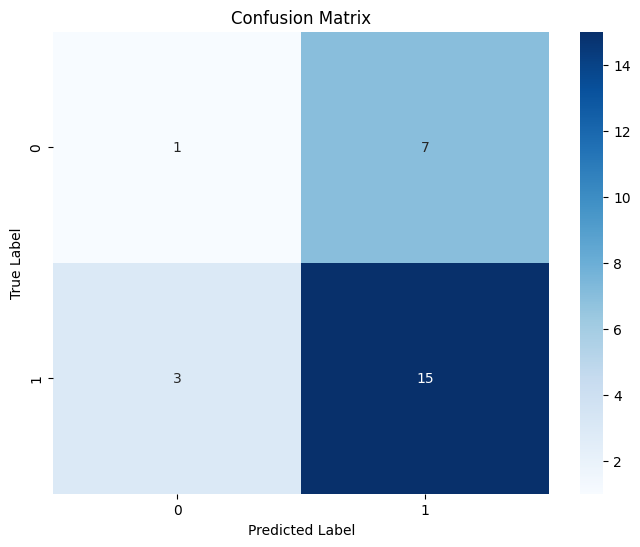

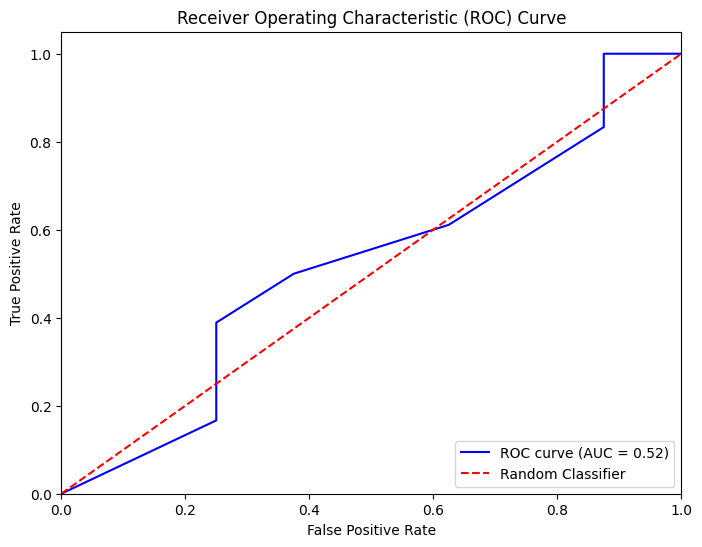

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
    
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()